In [50]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Train and Evaluate a single model

### Setup Parameters

In [51]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [52]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [53]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

max_ = traindf.Return.max()
min_ = traindf.Return.min()
# traindf = (traindf - min_) / (max_ - min_)
# validdf = (validdf - min_) / (max_ - min_)
# testdf = (testdf - min_) / (max_ - min_)

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

### Instanciate Model

In [66]:
model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            200,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [67]:
model.train(trainloader, validloader)

[00:00] Epoch 1/200 - Train Loss : 1.004240 / Val Loss : 1.011569
[00:03] Epoch 10/200 - Train Loss : 0.978700 / Val Loss : 1.016536
[00:07] Epoch 20/200 - Train Loss : 0.972567 / Val Loss : 1.021205
[00:10] Epoch 30/200 - Train Loss : 0.969949 / Val Loss : 1.022521
[00:14] Epoch 40/200 - Train Loss : 0.967625 / Val Loss : 1.023280
[00:18] Epoch 50/200 - Train Loss : 0.964915 / Val Loss : 1.024182
[00:21] Epoch 60/200 - Train Loss : 0.961534 / Val Loss : 1.025119
[00:25] Epoch 70/200 - Train Loss : 0.957221 / Val Loss : 1.025817
[00:29] Epoch 80/200 - Train Loss : 0.951696 / Val Loss : 1.026036
[00:33] Epoch 90/200 - Train Loss : 0.944706 / Val Loss : 1.025725
[00:37] Epoch 100/200 - Train Loss : 0.936104 / Val Loss : 1.025166
[00:40] Epoch 110/200 - Train Loss : 0.925962 / Val Loss : 1.024961
[00:44] Epoch 120/200 - Train Loss : 0.914641 / Val Loss : 1.025792
[00:48] Epoch 130/200 - Train Loss : 0.902697 / Val Loss : 1.028120
[00:52] Epoch 140/200 - Train Loss : 0.890673 / Val Loss : 

### Evaluation

In [57]:
model.evaluate(testloader)

Test MAE : 0.855519 | Test MAPE  : 16.328028 | Test RSME : 1.311961 | Test Theil-U 0.712446


RMSE : 1.1146601455872613
MAE : 0.8005597006268088
MAPE : 2.7542779516293856
TheilU : 0.8029203396526763


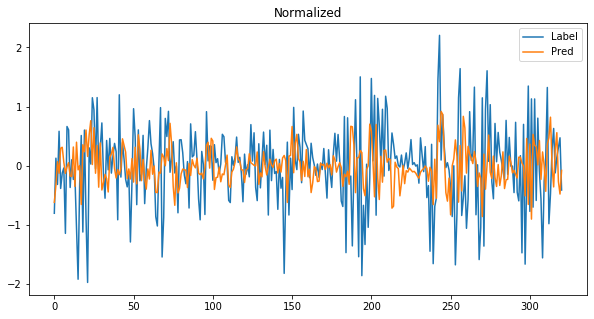

RMSE : 5.887671937673436e-05
MAE : 0.005818275602334458
MAPE : 2598937.3344319332
TheilU : 0.8012185210142357


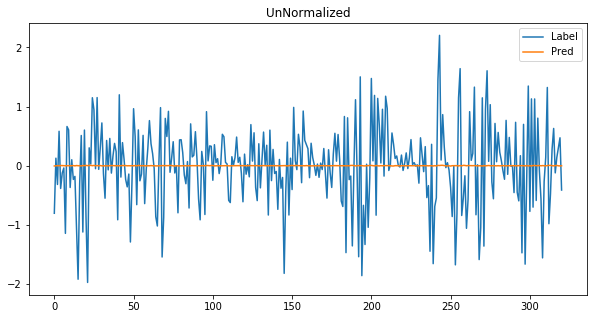

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import torch

preds, targets = [], []
model.model.eval()
with torch.no_grad():
    for features, target in testloader:
        outputs = model.model(features)
        preds += outputs.numpy().T.tolist()[0]
        targets += target.numpy().tolist()

preds = np.array(preds)
targets = np.array(targets)

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

plt.figure(figsize=(10,5))
plt.plot(labels, label="Label")
plt.plot(preds, label="Pred")
plt.title("Normalized")
plt.legend()
plt.show();

preds = np.array(preds)*testsigma + testmu
targets = np.array(targets)*testsigma + testmu

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

plt.figure(figsize=(10,5))
plt.plot(labels, label="Label")
plt.plot(preds, label="Pred")
plt.title("UnNormalized")
plt.legend();

## Train and Evaluate All Models

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.015053 / Val Loss : 0.353033
[00:59] Epoch 100/1000 - Train Loss : 0.922315 / Val Loss : 0.366432
[01:41] Epoch 200/1000 - Train Loss : 0.883410 / Val Loss : 0.378325
[02:20] Epoch 300/1000 - Train Loss : 0.825503 / Val Loss : 0.402828
[03:01] Epoch 400/1000 - Train Loss : 0.800735 / Val Loss : 0.421773
[03:43] Epoch 500/1000 - Train Loss : 0.768487 / Val Loss : 0.436990
[04:22] Epoch 600/1000 - Train Loss : 0.755920 / Val Loss : 0.451027
[05:00] Epoch 700/1000 - Train Loss : 0.750113 / Val Loss : 0.460184
[05:39] Epoch 800/1000 - Train Loss : 0.740508 / Val Loss : 0.470903
[06:18] Epoch 900/1000 - Train Loss : 0.735222 / Val Loss : 0.480294
[06:58] Epoch 1000/100

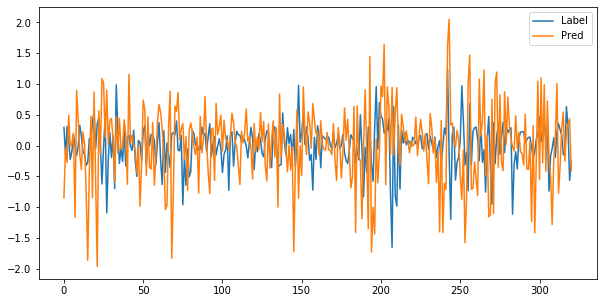




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.021662 / Val Loss : 0.353253
[00:53] Epoch 100/1000 - Train Loss : 0.786691 / Val Loss : 0.454012
[01:49] Epoch 200/1000 - Train Loss : 0.745627 / Val Loss : 0.473162
[02:46] Epoch 300/1000 - Train Loss : 0.728332 / Val Loss : 0.497646
[03:41] Epoch 400/1000 - Train Loss : 0.698024 / Val Loss : 0.546474
[04:36] Epoch 500/1000 - Train Loss : 0.690067 / Val Loss : 0.562039
[05:30] Epoch 600/1000 - Train Loss : 0.683953 / Val Loss : 0.573796
[06:28] Epoch 700/1000 - Train Loss : 0.678607 / Val Loss : 0.583870
[07:22] Epoch 800/1000 - Train Loss : 0.674927 / Val Loss : 0.589942
[08:16] Epoch 900/1000 - Train Loss : 0.672232 / Val Loss : 0.594369
[09:11] Epoch 1000/1000 - Train Loss : 0.670074 / Val Loss : 0.598034
Train MAE

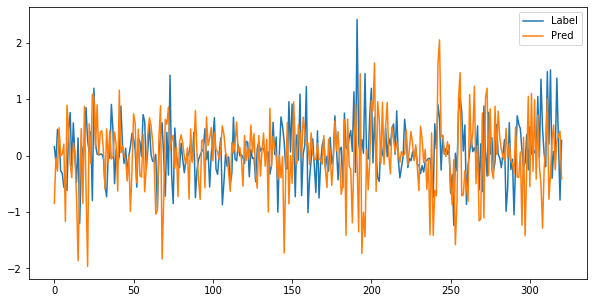




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.117780 / Val Loss : 0.352479
[00:33] Epoch 100/1000 - Train Loss : 0.947221 / Val Loss : 0.355548
[01:07] Epoch 200/1000 - Train Loss : 0.947214 / Val Loss : 0.355548
[01:45] Epoch 300/1000 - Train Loss : 0.943769 / Val Loss : 0.355548
[02:21] Epoch 400/1000 - Train Loss : 0.943769 / Val Loss : 0.355548
[02:55] Epoch 500/1000 - Train Loss : 0.941066 / Val Loss : 0.355548
[03:31] Epoch 600/1000 - Train Loss : 0.921930 / Val Loss : 0.355548
[04:06] Epoch 700/1000 - Train Loss : 0.921926 / Val Loss : 0.355548
[04:41] Epoch 800/1000 - Train Loss : 0.945339 / Val Loss : 0.355548
[05:17] Epoch 900/1000 - Train Loss : 0.945338 / Val Loss : 0.355548
[05:54] Epoch 1000/1000 - Train Loss : 0.945338 / Val Loss : 0.355548
Train MAE : 0.6726 | Train MAPE 

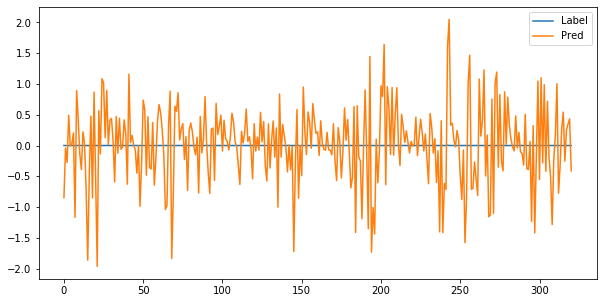




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.007719 / Val Loss : 0.362303
[00:38] Epoch 100/1000 - Train Loss : 0.938620 / Val Loss : 0.376910
[01:18] Epoch 200/1000 - Train Loss : 0.842281 / Val Loss : 0.393965
[01:59] Epoch 300/1000 - Train Loss : 0.746537 / Val Loss : 0.422645
[02:38] Epoch 400/1000 - Train Loss : 0.700163 / Val Loss : 0.450782
[03:17] Epoch 500/1000 - Train Loss : 0.684153 / Val Loss : 0.478547
[03:57] Epoch 600/1000 - Train Loss : 0.674057 / Val Loss : 0.492003
[04:36] Epoch 700/1000 - Train Loss : 0.664512 / Val Loss : 0.494301
[05:14] Epoch 800/1000 - Train Loss : 0.655175 / Val Loss : 0.491868
[05:53] Epoch 900/1000 - Train Loss : 0.645859 / Val Loss : 0.492645
[06:29] Epoch 1000/

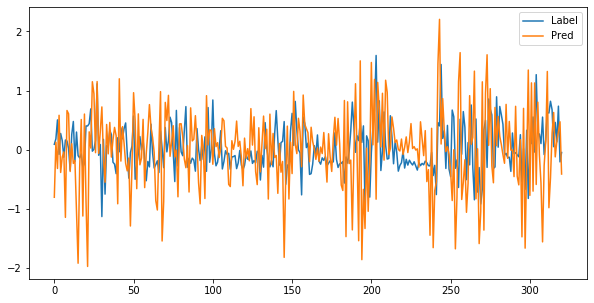




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.055011 / Val Loss : 0.367680
[00:51] Epoch 100/1000 - Train Loss : 0.790889 / Val Loss : 0.523064
[01:42] Epoch 200/1000 - Train Loss : 0.715317 / Val Loss : 0.628846
[02:32] Epoch 300/1000 - Train Loss : 0.697837 / Val Loss : 0.632471
[03:22] Epoch 400/1000 - Train Loss : 0.691015 / Val Loss : 0.643408
[04:16] Epoch 500/1000 - Train Loss : 0.686323 / Val Loss : 0.650048
[05:12] Epoch 600/1000 - Train Loss : 0.682420 / Val Loss : 0.653246
[06:06] Epoch 700/1000 - Train Loss : 0.679004 / Val Loss : 0.654056
[06:58] Epoch 800/1000 - Train Loss : 0.675878 / Val Loss : 0.653133
[07:55] Epoch 900/1000 - Train Loss : 0.672555 / Val Loss : 0.649196
[08:53] Epoch 1000/1000 - Train Loss : 0.669474 / Val Loss : 0.648810
Train MAE

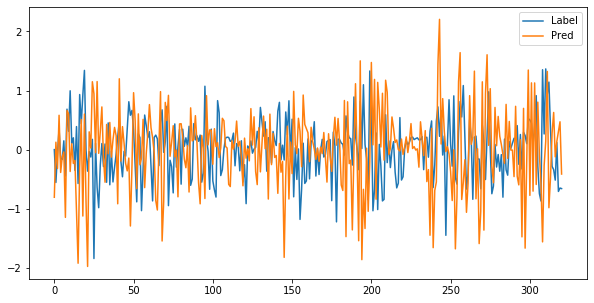




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.117310 / Val Loss : 0.472334
[00:46] Epoch 100/1000 - Train Loss : 0.957427 / Val Loss : 0.358181
[01:24] Epoch 200/1000 - Train Loss : 0.957430 / Val Loss : 0.358181
[01:59] Epoch 300/1000 - Train Loss : 0.957112 / Val Loss : 0.358181
[02:34] Epoch 400/1000 - Train Loss : 0.957424 / Val Loss : 0.358181
[03:09] Epoch 500/1000 - Train Loss : 0.957430 / Val Loss : 0.358181
[03:42] Epoch 600/1000 - Train Loss : 0.957415 / Val Loss : 0.358181
[04:14] Epoch 700/1000 - Train Loss : 0.957429 / Val Loss : 0.358181
[04:46] Epoch 800/1000 - Train Loss : 0.957430 / Val Loss : 0.358181
[05:18] Epoch 900/1000 - Train Loss : 0.957573 / Val Loss : 0.358181
[05:50] Epoch 1000/1000 - Train Loss : 0.957430 / Val Loss : 0.358181
Train MAE : 0.6891 | Train MAPE 

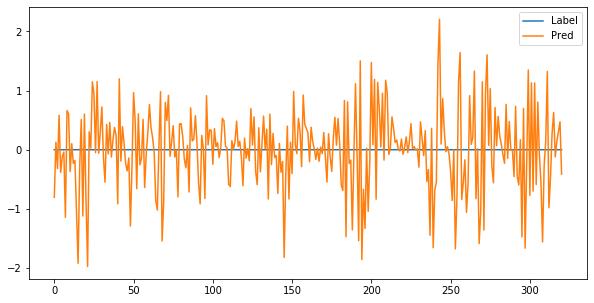




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.031103 / Val Loss : 0.386981
[00:37] Epoch 100/1000 - Train Loss : 0.924876 / Val Loss : 0.382423
[01:14] Epoch 200/1000 - Train Loss : 0.792380 / Val Loss : 0.407373
[01:50] Epoch 300/1000 - Train Loss : 0.714270 / Val Loss : 0.470604
[02:25] Epoch 400/1000 - Train Loss : 0.665852 / Val Loss : 0.504270
[03:00] Epoch 500/1000 - Train Loss : 0.656915 / Val Loss : 0.521150
[03:35] Epoch 600/1000 - Train Loss : 0.654634 / Val Loss : 0.531300
[04:10] Epoch 700/1000 - Train Loss : 0.653391 / Val Loss : 0.538097
[04:45] Epoch 800/1000 - Train Loss : 0.652427 / Val Loss : 0.543612
[05:22] Epoch 900/1000 - Train Loss : 0.651551 / Val Loss : 0.548469
[06:04] Epoch 1000/

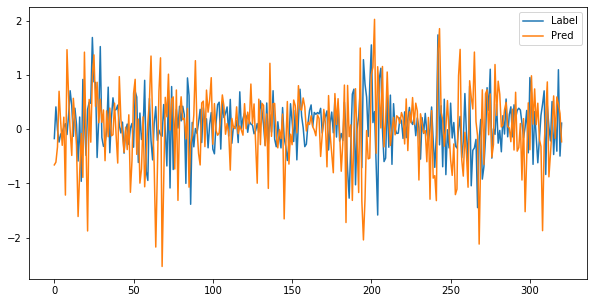




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.042440 / Val Loss : 0.382738
[00:54] Epoch 100/1000 - Train Loss : 0.748732 / Val Loss : 0.482901
[01:45] Epoch 200/1000 - Train Loss : 0.666512 / Val Loss : 0.511442
[02:36] Epoch 300/1000 - Train Loss : 0.644165 / Val Loss : 0.532144
[03:27] Epoch 400/1000 - Train Loss : 0.631238 / Val Loss : 0.555338
[04:18] Epoch 500/1000 - Train Loss : 0.621810 / Val Loss : 0.553136
[05:09] Epoch 600/1000 - Train Loss : 0.614949 / Val Loss : 0.555323
[06:07] Epoch 700/1000 - Train Loss : 0.611490 / Val Loss : 0.559492
[07:04] Epoch 800/1000 - Train Loss : 0.609163 / Val Loss : 0.561962
[08:02] Epoch 900/1000 - Train Loss : 0.607030 / Val Loss : 0.564015
[08:59] Epoch 1000/1000 - Train Loss : 0.605015 / Val Loss : 0.566437
Train M

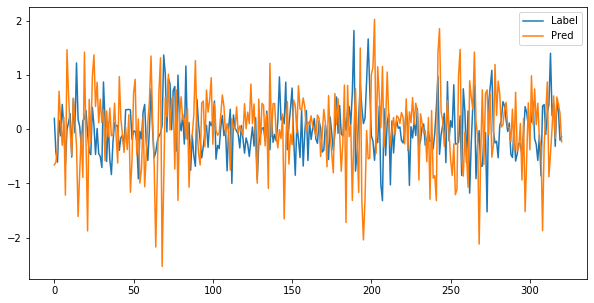




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/1000 - Train Loss : 1.058429 / Val Loss : 0.377456
[00:35] Epoch 100/1000 - Train Loss : 0.972330 / Val Loss : 0.385797
[01:11] Epoch 200/1000 - Train Loss : 0.972351 / Val Loss : 0.385736
[01:48] Epoch 300/1000 - Train Loss : 0.979504 / Val Loss : 0.387325
[02:24] Epoch 400/1000 - Train Loss : 0.965514 / Val Loss : 0.400736
[03:00] Epoch 500/1000 - Train Loss : 0.964748 / Val Loss : 0.402633
[03:36] Epoch 600/1000 - Train Loss : 0.964765 / Val Loss : 0.396633
[04:12] Epoch 700/1000 - Train Loss : 0.962413 / Val Loss : 0.393766
[04:48] Epoch 800/1000 - Train Loss : 0.950501 / Val Loss : 0.392650
[05:24] Epoch 900/1000 - Train Loss : 0.971896 / Val Loss : 0.397865
[06:00] Epoch 1000/1000 - Train Loss : 0.974640 / Val Loss : 0.388640
Train MAE : 0.7173 | Train MAPE 

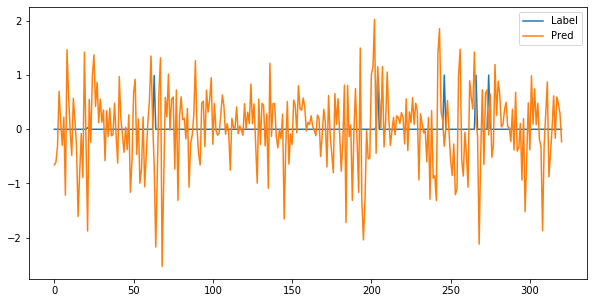

In [3]:
models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'

        mu, sigma = traindf.Return.mean(), traindf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)

        model = NN.Model(NNtype)
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    1000,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        model.evaluate(testloader)
        
        preds, labels = model.Getevaluation(testloader)
        
        plt.figure(figsize=(10,5))
        plt.plot(labels, label="Label")
        plt.plot(preds, label="Pred")
        plt.legend()
        plt.show()
        
        models[ETF][NNtype] = model
        print("\n"*2)

### Save Models

In [12]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [71]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005390 | Test MAPE  : 3.646229 | Test RSME : 0.000052 | Test Theil-U 0.926919


# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

# To work

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [15]:
Table4

,Statistic,MLP,RNN,PSN
ETF,,,,
SPY,MAE,0.005533,0.005745,0.005533
SPY,MAPE,1.167107,1.459932,1.501336
SPY,RMSE,0.000055,0.000060,0.000055
SPY,THEIL-U,0.925617,0.819338,0.858615
DIA,MAE,0.005420,0.005653,0.005405
DIA,MAPE,1.971646,2.648959,5.369128
DIA,RMSE,0.000053,0.000055,0.000054
DIA,THEIL-U,0.910827,0.836283,0.855665
QQQ,MAE,0.006660,0.006684,0.006594
